# Load packages and set global settings

Imports and set up paths for output data. Doing settings for scanpy plottings. 

In [1]:
import anndata
import numpy as np
import scanpy as sc
import sys
import pandas as pd
import seaborn as sb
import scipy
import matplotlib.pyplot as plt
import types
import os
import pickle
import cellflow
import cellflow.preprocessing as cfpp
from importlib.metadata import version

print(version('scanpy'))
print(anndata.__version__)

np.random.seed(seed=42)

1.11.5
0.11.4


In [2]:
# current working dir
root_dir = './'

# set output paths
results_dir = root_dir + 'results/'
dir_out = results_dir + 'figures/'
dir_anndata = results_dir + 'anndata/'
dir_tfmatrix = results_dir + 'csv/'
dir_model = results_dir + 'model/'

In [3]:
# scanpy plotting settings
sc.settings.set_figure_params(dpi=80, dpi_save=600, scanpy=True)
sc.settings.figdir = dir_out

# Load data

Read the anndata object (observed cell states) and 48TF matrix (perturbation conditions).

In [4]:
adata_assigned_filtered_path = dir_anndata + 'adata_assigned_filtered.h5ad'
tfmatrix_assigned_filtered_path = dir_tfmatrix + 'tfmatrix_assigned_filtered.csv'

adata_assigned_filtered = sc.read_h5ad(adata_assigned_filtered_path)
print(f"AnnData reloaded: {adata_assigned_filtered.shape}")
csv_assigned_filtered = pd.read_csv(tfmatrix_assigned_filtered_path, index_col=0)
print(f"TF matrix reloaded: {csv_assigned_filtered.shape}")

AnnData reloaded: (26764, 36745)
TF matrix reloaded: (26764, 48)


In [5]:
adata = adata_assigned_filtered
tfmatrix = csv_assigned_filtered

# Create "condition" details

Select 12 key TFs from all 48 types to create the perturbation condition representation for CellFlow. Binary encoding is used to indicate whether each TF was perturbed (1) or not (0) in the reprogramming experiment for each cell.

In [6]:
#  Generate conditional keys and conditional dictionaries
focus_tfs = ['SPI1', 'NFIL3', 'KLF4', 'BATF3', 'NR4A1', 'MYCL', 
                 'JUNB', 'ARID5A', 'NFKB1', 'HHEX', 'IRF8', 'IRF4']
condition_keys = focus_tfs.copy()
condition_dict = {}
for i, tf in enumerate(focus_tfs):
    vec = np.zeros(len(focus_tfs))
    vec[i] = 1.0
    condition_dict[tf] = vec

# Add a condition tag to the adata
for tf in focus_tfs:
    if tf not in adata.obs.columns:
        adata.obs[tf] = (tfmatrix[tf].values > 0)
    else:
        adata.obs[tf] = (adata.obs[tf] > 0)

# save to adata.uns
adata.uns['conditions'] = condition_dict

In [7]:
# Check the conditional keys and example output
print(f"Condition keys: {len(condition_keys)}")
print(f"Keys: {condition_keys}")
print(f"\nexample vec:")
print(f"SPI1:  {condition_dict['SPI1']}")
print(f"IRF8:  {condition_dict['IRF8']}")
print(f"\nadata.obs TF cols(firsst 5)）:")
print(adata.obs[focus_tfs].head())

Condition keys: 12
Keys: ['SPI1', 'NFIL3', 'KLF4', 'BATF3', 'NR4A1', 'MYCL', 'JUNB', 'ARID5A', 'NFKB1', 'HHEX', 'IRF8', 'IRF4']

example vec:
SPI1:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
IRF8:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]

adata.obs TF cols(firsst 5)）:
           SPI1  NFIL3   KLF4  BATF3  NR4A1   MYCL   JUNB  ARID5A  NFKB1  \
D2_45022  False  False  False  False  False  False  False   False  False   
D2_54128  False   True  False  False   True  False  False   False  False   
D2_63824  False  False   True  False   True   True  False    True   True   
D2_75523  False  False  False  False  False  False  False   False  False   
D2_77263  False  False   True  False   True   True  False   False  False   

           HHEX   IRF8   IRF4  
D2_45022  False  False  False  
D2_54128  False   True   True  
D2_63824  False   True   True  
D2_75523  False  False  False  
D2_77263  False  False  False  


# Train/test split

Split the data into train and test set. The SPI1+IRF8 is a particularly interesting combination from known study, as SPI1 is a universal myeloid factor, while IRF8 specializes in DC fate. We now want to test whether CellFlow can predict the resulting cell states from SPI1+IRF8 perturbation (new perturbation conditions for model) by holding out all cells with the SPI1+IRF8 perturbation combination.

In [8]:
# Split train and test set
holdout_mask = (adata.obs['IRF8'] == True) & (adata.obs['SPI1'] == True)
adata_test = adata[holdout_mask].copy()
adata_train = adata[~holdout_mask].copy()

print(f"train set: {adata_train.shape[0]} cells")
print(f"test set: {adata_test.shape[0]} cells")

train set: 24604 cells
test set: 2160 cells


In [9]:
# select HVG on train set
print("selecting HVG...")
sc.pp.highly_variable_genes(adata_train, n_top_genes=4000, flavor='seurat')
hvg = adata_train.var['highly_variable']
print(f"{hvg.sum()} HVGs has beec selected")

# keep HVG
adata_train = adata_train[:, hvg].copy()
adata_test = adata_test[:, hvg].copy()
print(f"adata_train: {adata_train.shape}")
print(f"adata_test: {adata_test.shape}")

# calculating PCA and projecting
print("calculating PCA...")
cfpp.centered_pca(adata_train, n_comps=30, method='scanpy')
print("projecting PCA...")
cfpp.project_pca(adata_test, adata_train)

print(f"\nPCA completed:")
print(f"adata_train.obsm['X_pca']: {adata_train.obsm['X_pca'].shape}")
print(f"adata_test.obsm['X_pca']: {adata_test.obsm['X_pca'].shape}")

selecting HVG...
4000 HVGs has beec selected
adata_train: (24604, 4000)
adata_test: (2160, 4000)
calculating PCA...
projecting PCA...

PCA completed:
adata_train.obsm['X_pca']: (24604, 30)
adata_test.obsm['X_pca']: (2160, 30)


# Generating a source distribution

To train the model and generate predictions, we also need a source distribution to generate from. In most experiments with unperturbed control cells, the control condition serves as a natural source distribution. However, in this case, each condition generates distinct cell state distributions. This means that the control condition cannot be viewed as an “unperturbed” state and it therefore does not necessarily make sense to use it as a source distribution. Instead, we use a random distribution that is generated from subsamples means of the training data. As a result, the model will essentially act in a fully generative way, generating new cell distributions from a random source.

In [10]:
# Generating a source distribution
from scipy.sparse import csr_matrix

n_src_cells = adata_test.shape[0]
n_samples = 1000
sample_rep = 'X_pca'

print("Generating a source distribution...")
samples = []
for i in range(n_src_cells):
    sample = adata_train.obsm[sample_rep][
        np.random.choice(adata_train.n_obs, n_samples), :
    ].mean(axis=0)
    samples.append(sample)
samples = np.array(samples)

# create source adata
samples_obs = pd.DataFrame(index=range(samples.shape[0]))

# add TF cols
for tf in focus_tfs:
    samples_obs[tf] = False

samples_obs['CTRL'] = True

adata_ctrl = anndata.AnnData(
    X=csr_matrix(np.zeros((samples.shape[0], adata_train.n_vars))),
    obs=samples_obs
)
adata_ctrl.obsm[sample_rep] = samples
adata_ctrl.var_names = adata_train.var_names

print(f"Source cells: {adata_ctrl.shape}")

# add CTRL col fot train set
adata_train.obs['CTRL'] = False

# Merge the train set and source
adata_train_full = anndata.concat([adata_train, adata_ctrl], join='outer')
adata_train_full.obs['CTRL'] = adata_train_full.obs['CTRL'].fillna(False)
adata_train_full.uns = adata_train.uns.copy()
adata_ctrl.uns = adata_train.uns.copy()
adata_test.uns = adata_train.uns.copy()

print(f"\nfull train set: {adata_train_full.shape[0]} cells")
print(f"  - train: {(~adata_train_full.obs['CTRL']).sum()}")
print(f"  - Source: {adata_train_full.obs['CTRL'].sum()}")

Generating a source distribution...


/home/inf-48-2024/anaconda3/envs/cellflow/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/inf-48-2024/anaconda3/envs/cellflow/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Source cells: (2160, 4000)

full train set: 26764 cells
  - train: 24604
  - Source: 2160


# Set up the generative model CellFlow

Now set up the CellFlow model. We use the default deterministic otfm solver for this task.

In [11]:
import cellflow.model
cf = cellflow.model.CellFlow(adata_train_full, solver="otfm")
print("CellFlow model initialized with solver='otfm'")

CellFlow model initialized with solver='otfm'


# Preparing CellFlow's data handling with prepare_data()

We set up the data as follows:
We use .obsm["X_pca"] as the cellular representation (sample_rep); "CTRL" indicated the source distribution we constructed earlier; We use the previously constructed binary columns indicating TF status as perturbation_covariates and one-hot vectors to be perturbation_covariate_reps.

In [12]:
# Prepare data
print("Preparing data...")
cf.prepare_data(
    sample_rep='X_pca',
    perturbation_covariates={'conditions': condition_keys},
    perturbation_covariate_reps={'conditions': 'conditions'},
    control_key='CTRL'
)

/home/inf-48-2024/anaconda3/envs/cellflow/lib/python3.10/site-packages/cellflow/data/_datamanager.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index


Preparing data...


100%|██████████████████████████████████████| 1573/1573 [00:06<00:00, 259.37it/s]


# Prepare CellFlow's model architechture with prerpare_model()

Now we set up the architecture of the CellFlow model with recomanded hyperparameters.

In [13]:
from functools import partial
from ott.solvers import utils as solver_utils
import flax.linen as nn

print("Prepareing model...")

# Define the network structure
layers_before_pool = [{
    "layer_type": "mlp",
    "dims": [2048] * 4,
    "dropout_rate": 0.0,
    "act_fn": nn.relu,
}]
layers_after_pool = []

# Define matching function
match_fn = partial(
    solver_utils.match_linear,
    epsilon=0.5,
    scale_cost="mean",
    tau_a=0.99,
    tau_b=0.99,
)

cf.prepare_model(
    condition_embedding_dim=128,
    time_encoder_dims=[1024] * 5,
    time_encoder_dropout=0.1,
    hidden_dims=[2048] * 2 + [128],
    hidden_dropout=0.2,
    decoder_dims=[512] * 2,
    decoder_dropout=0.1,
    pooling="mean",
    layers_before_pool=layers_before_pool,
    layers_after_pool=layers_after_pool,
    cond_output_dropout=0.3,
    probability_path={"constant_noise": 0.0},
    match_fn=match_fn
)

print("Model preparation complete！")

Prepareing model...
Model preparation complete！


# Train model

Now we train the model. To make training quicker, we here don’t compute validation metrics during training, but only evaluare predictions afterwards.

In [ ]:
# Training
# cf.train(num_iterations=10000)

In [14]:
from pathlib import Path
import time

# Training configuration
total_iterations = 12000
checkpoint_every = 2000
cf_model_dir = dir_model + "cellflow_checkpoints/"
Path(cf_model_dir).mkdir(exist_ok=True)

print("Starting training...")
print(f"Total iterations: {total_iterations:,}")
print(f"Saving checkpoint every {checkpoint_every:,} iterations")

num_checkpoints = total_iterations // checkpoint_every
for i in range(num_checkpoints):
    start_iter = i * checkpoint_every
    end_iter = start_iter + checkpoint_every
    
    print(f"\n{'='*60}")
    print(f"Training iteration {start_iter:,} - {end_iter:,}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # Train
    cf.train(num_iterations=checkpoint_every)
    elapsed = time.time() - start_time
    
    # Save checkpoint
    checkpoint_path = f"{cf_model_dir}/checkpoint_{end_iter}"
    Path(checkpoint_path).mkdir(parents=True, exist_ok=True)
    cf.save(checkpoint_path, overwrite=True)
    
    print(f"✓ Checkpoint saved to: {checkpoint_path}")
    print(f"  Time elapsed: {elapsed/60:.1f} minutes")

print("\nTraining completed!")

Starting training...
Total iterations: 12,000
Saving checkpoint every 2,000 iterations

Training iteration 0 - 2,000


100%|████████████████████████████| 2000/2000 [43:06<00:00,  1.29s/it, loss=3.85]


✓ Checkpoint saved to: ./results/model/cellflow_checkpoints//checkpoint_2000
  Time elapsed: 43.1 minutes

Training iteration 2,000 - 4,000


100%|████████████████████████████| 2000/2000 [43:01<00:00,  1.29s/it, loss=1.79]


✓ Checkpoint saved to: ./results/model/cellflow_checkpoints//checkpoint_4000
  Time elapsed: 43.0 minutes

Training iteration 4,000 - 6,000


100%|████████████████████████████| 2000/2000 [43:01<00:00,  1.29s/it, loss=1.36]


✓ Checkpoint saved to: ./results/model/cellflow_checkpoints//checkpoint_6000
  Time elapsed: 43.0 minutes

Training iteration 6,000 - 8,000


100%|████████████████████████████| 2000/2000 [43:01<00:00,  1.29s/it, loss=1.15]


✓ Checkpoint saved to: ./results/model/cellflow_checkpoints//checkpoint_8000
  Time elapsed: 43.0 minutes

Training iteration 8,000 - 10,000


100%|████████████████████████████| 2000/2000 [43:16<00:00,  1.30s/it, loss=1.01]


✓ Checkpoint saved to: ./results/model/cellflow_checkpoints//checkpoint_10000
  Time elapsed: 43.3 minutes

Training iteration 10,000 - 12,000


100%|███████████████████████████| 2000/2000 [43:09<00:00,  1.29s/it, loss=0.919]


✓ Checkpoint saved to: ./results/model/cellflow_checkpoints//checkpoint_12000
  Time elapsed: 43.2 minutes

Training completed!


In [15]:
# load model
cf_model_dir = dir_model + "cellflow_checkpoints/"
cf_final = cellflow.model.CellFlow.load(f"{cf_model_dir}/checkpoint_12000")

print(f"model loaded！")

model loaded！


# Make predictions

Now we can finally check out the predictions. we use predict() to generate predictions for the held-out condition in the validation dataset. To visualize the predictions, we can use UMAP. We can also inspect the predictions through looking at marginal distributions on principal components. This can give some insight into how cell distributions are predicted.

In [16]:
# Prepare held-out condition data

print("\nPreparing held-out condition data...")
obs_pred = pd.DataFrame(index=[0])
# select TF combination: SPIT1+IRF8 to predict
focus_tfs = ['SPI1', 'NFIL3', 'KLF4', 'BATF3', 'NR4A1', 'MYCL', 
             'JUNB', 'ARID5A', 'NFKB1', 'HHEX', 'IRF8', 'IRF4']
for tf in focus_tfs:
    if tf in ['IRF8', 'SPI1']:
        obs_pred[tf] = True
    else:
        obs_pred[tf] = False

print(f"Data preparation complete!")
print(f"\nTF combination to predict:")
print(obs_pred[focus_tfs])


Preparing held-out condition data...
Data preparation complete!

TF combination to predict:
   SPI1  NFIL3   KLF4  BATF3  NR4A1   MYCL   JUNB  ARID5A  NFKB1   HHEX  IRF8  \
0  True  False  False  False  False  False  False   False  False  False  True   

    IRF4  
0  False  


In [17]:
# make sure adata_ctrl has correct uns
adata_ctrl.uns = adata_train.uns.copy()
print(f"Source data prepared: {adata_ctrl.shape}")

# prediction
print("\nStart predicting...")
x_pred = cf_final.predict(
    adata_ctrl,
    sample_rep='X_pca',
    covariate_data=obs_pred
)

print(f"Prediction complete!")
print(f"  Check keys: {list(x_pred.keys())}")
print(f"  Shape: {list(x_pred.values())[0].shape}")

Source data prepared: (2160, 4000)

Start predicting...


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 142.21it/s]


Prediction complete!
  Check keys: [(True, False, False, False, False, False, False, False, False, False, True, False)]
  Shape: (2160, 30)


In [18]:
# convert predicted data to anndata object

from scipy.sparse import csr_matrix

adatas_pred = []
for condition_idx in x_pred.keys():
    adata_pred_single = anndata.AnnData(X=adata_ctrl.X)
    adata_pred_single.obs['condition'] = 'IRF8+SPI1'
    adata_pred_single.obsm['X_pca'] = x_pred[condition_idx]
    adata_pred_single.var_names = adata_ctrl.var_names
    adatas_pred.append(adata_pred_single)
adata_pred = anndata.concat(adatas_pred, join='outer')

print(f"  AnnData creation complete!")
print(f"  Shape: {adata_pred.shape}")
print(f"  Obs columns: {list(adata_pred.obs.columns)}")
print(f"  X_pca shape: {adata_pred.obsm['X_pca'].shape}")

  AnnData creation complete!
  Shape: (2160, 4000)
  Obs columns: ['condition']
  X_pca shape: (2160, 30)


In [19]:
# reconstruct the PCA space where the predictions were made to obtain gene expression values for predictions

cfpp.reconstruct_pca(adata_pred, use_rep='X_pca', ref_adata=adata_train)
adata_pred.X = csr_matrix(adata_pred.layers['X_recon'])
del adata_pred.layers['X_recon']

print(f"  X shape: {adata_pred.X.shape}")
print(f"  X type: {type(adata_pred.X)}")

  X shape: (2160, 4000)
  X type: <class 'scipy.sparse._csr.csr_matrix'>


In [20]:
# reproject the predictions into a new PCA space with the full ground truth data

print("\ncalculate new PCA with full data...")
adata_full = anndata.concat([adata_train, adata_test])
cfpp.centered_pca(adata_full, n_comps=30, method='scanpy')

print(f"new PCA: {adata_full.obsm['X_pca'].shape}")

# reproject
cfpp.project_pca(adata_pred, adata_full, obsm_key_added='X_pca_reproj')

print(f"Reproject complete!")
print(f"X_pca_reproj shape: {adata_pred.obsm['X_pca_reproj'].shape}")


calculate new PCA with full data...
new PCA: (26764, 30)
Reproject complete!
X_pca_reproj shape: (2160, 30)


In [21]:
# visualize the predictions with UMAP

import umap

print("\nUMAP on full data...")
umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    n_epochs=500,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.4,
    spread=1.0,
    random_state=42,
)

# compute an embedding from the full dataset
adata_full.obsm['X_umap'] = umap_model.fit_transform(adata_full.obsm['X_pca'])
print(f"UMAP on full data: {adata_full.obsm['X_umap'].shape}")

# transform pred data to UMAP spcae
adata_pred.obsm['X_umap'] = umap_model.transform(adata_pred.obsm['X_pca_reproj'])
print(f"UMAP for prediction complete: {adata_pred.obsm['X_umap'].shape}")


UMAP on full data...


/home/inf-48-2024/anaconda3/envs/cellflow/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP on full data: (26764, 2)
UMAP for prediction complete: (2160, 2)


Cell counts for different conditions:
  IRF8 cells: 3285
  SPI1 cells: 4108
  IRF8+SPI1 cells: 2160


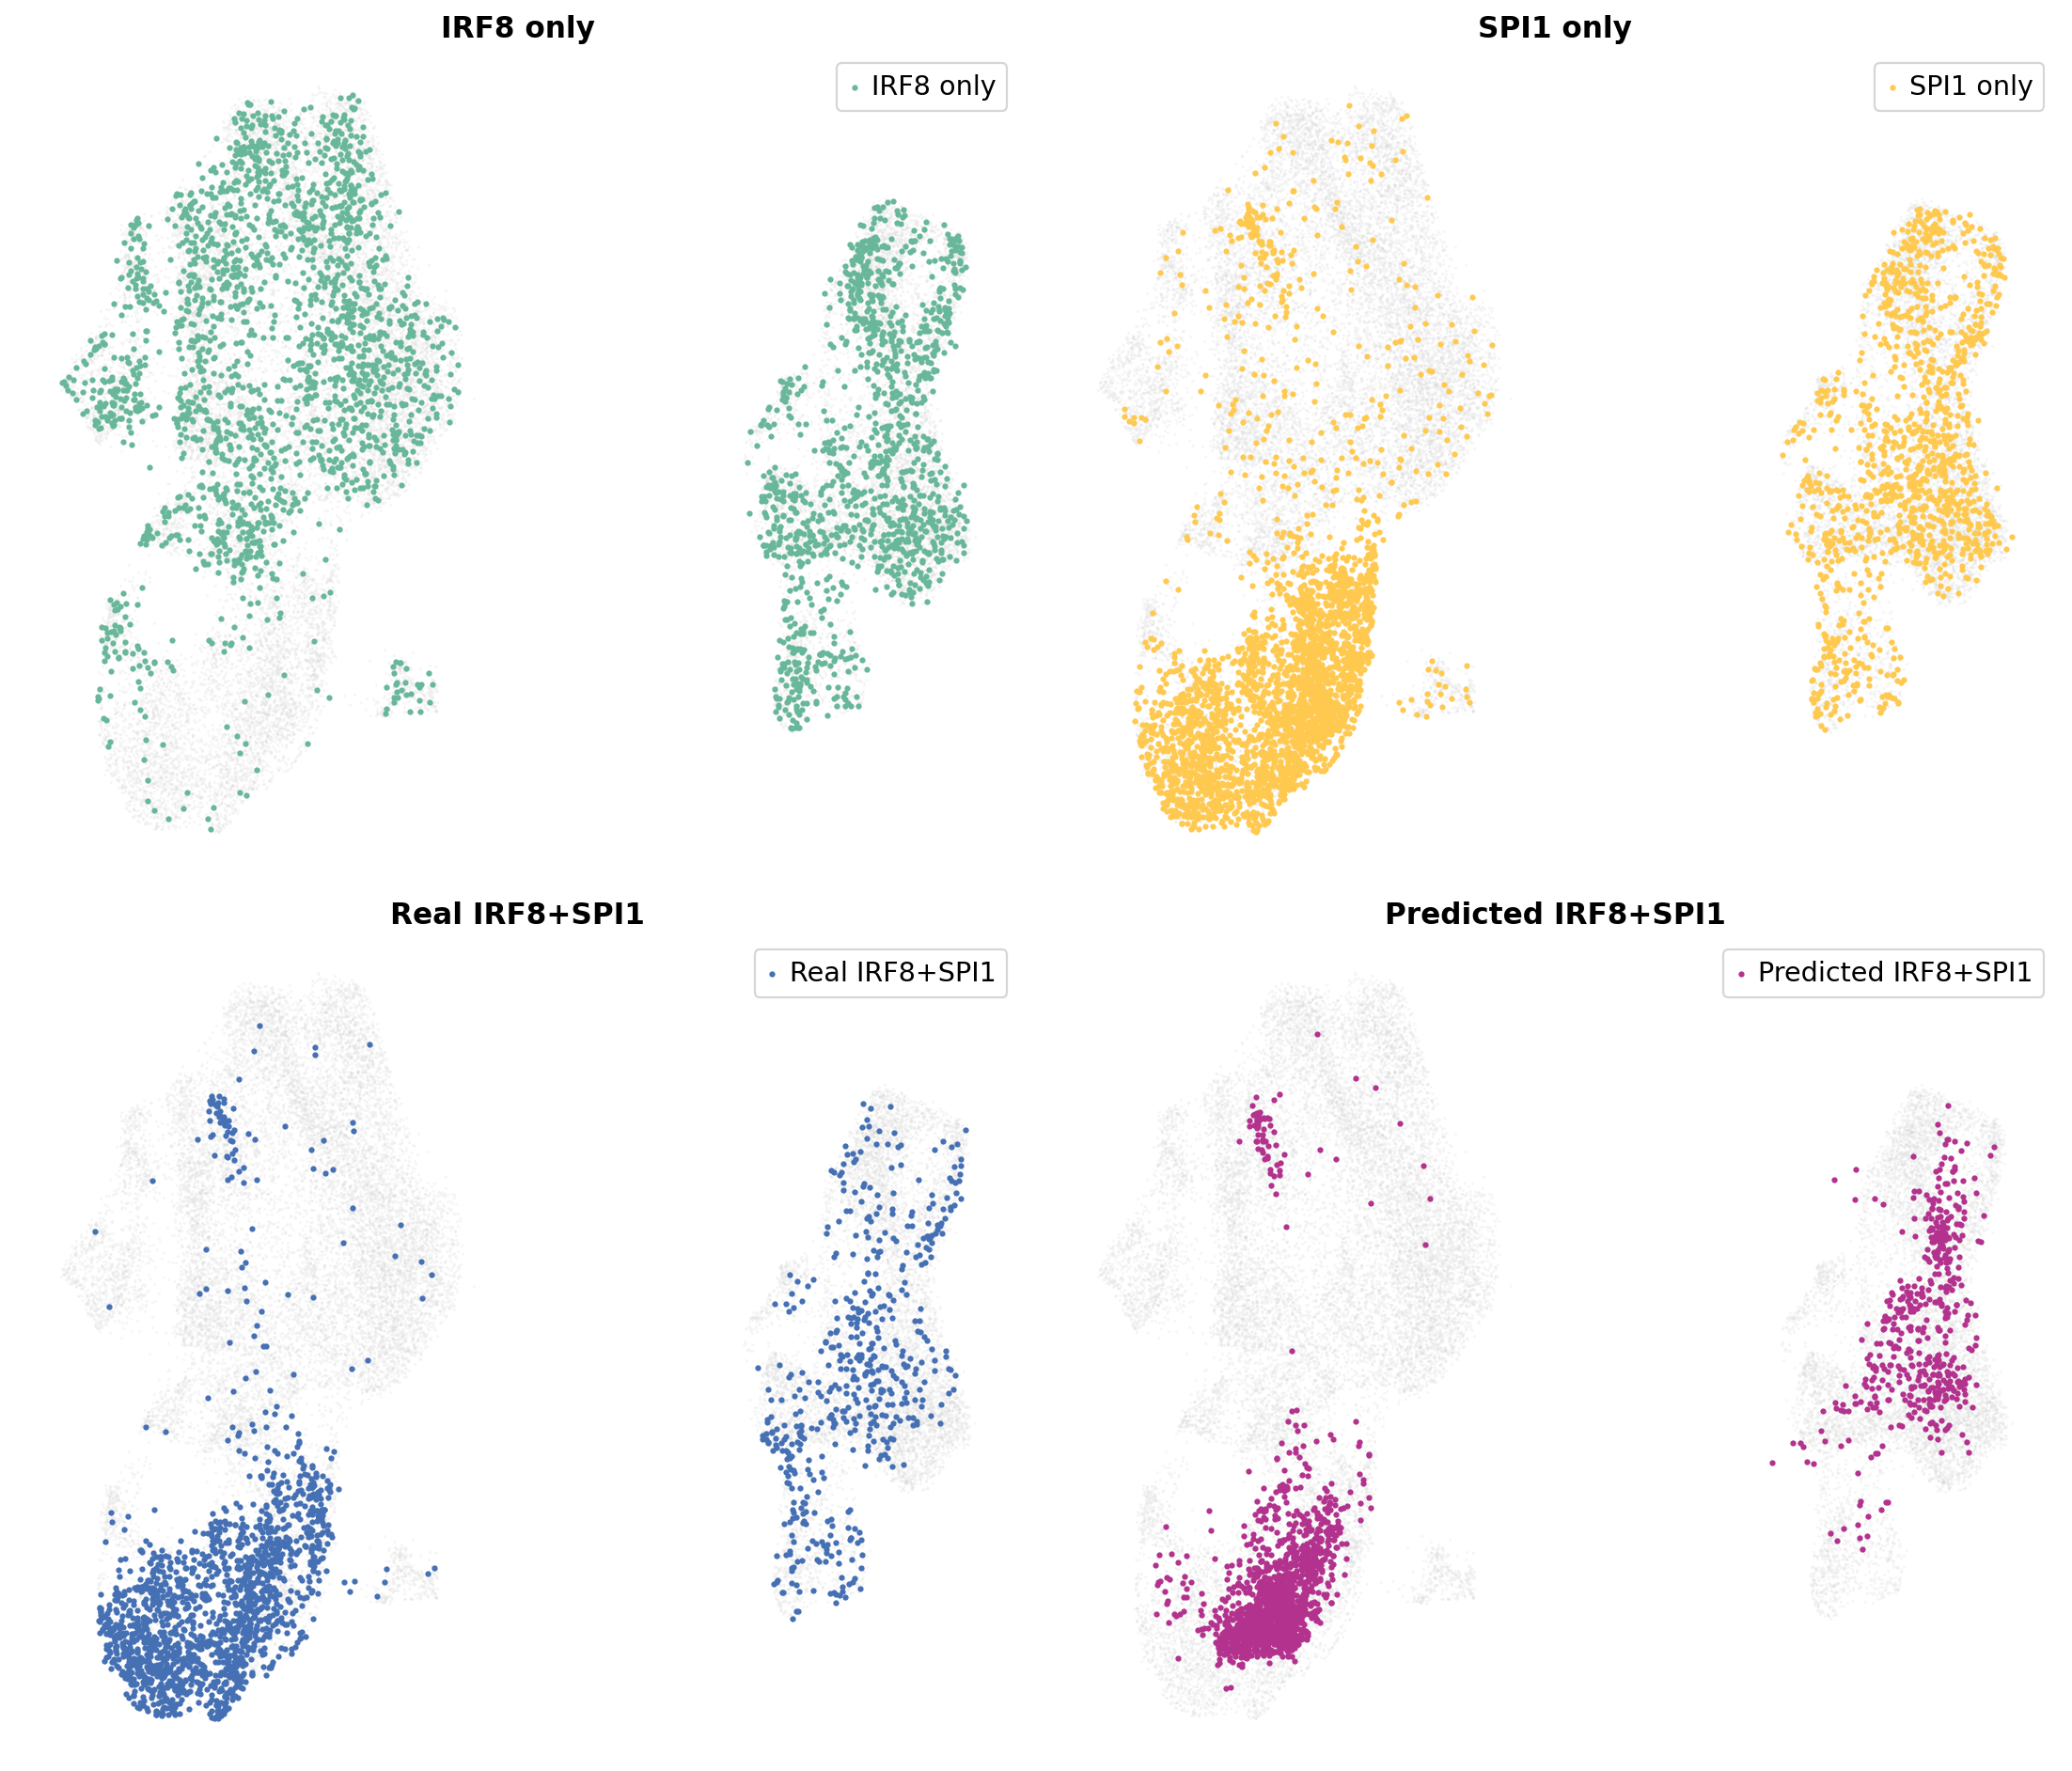

In [22]:
# Visualize prediction results compared by real data

import matplotlib.pyplot as plt
import seaborn as sns

# prepare plotting data
# extract train and test dataset from adata_full
n_train = adata_train.shape[0]
n_test = adata_test.shape[0]
umap_train = adata_full.obsm['X_umap'][:n_train]
umap_test = adata_full.obsm['X_umap'][n_train:]

# extract single IRF8 and SPI1 from train set
mask_irf8_only = (adata_train.obs['IRF8'] == True) & (adata_train.obs['SPI1'] == False)
mask_spi1_only = (adata_train.obs['SPI1'] == True) & (adata_train.obs['IRF8'] == False)
umap_irf8_only = umap_train[mask_irf8_only]
umap_spi1_only = umap_train[mask_spi1_only]

print("Cell counts for different conditions:")
print(f"  IRF8 cells: {mask_irf8_only.sum()}")
print(f"  SPI1 cells: {mask_spi1_only.sum()}")
print(f"  IRF8+SPI1 cells: {n_test}")

# create 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()

def plot_background(ax):
    sns.scatterplot(
        x=adata_full.obsm['X_umap'][:, 0],
        y=adata_full.obsm['X_umap'][:, 1],
        c='lightgrey',
        s=2,
        alpha=0.2,
        linewidth=0,
        ax=ax
    )

# IRF8
ax = axs[0]
plot_background(ax)
sns.scatterplot(
    x=umap_irf8_only[:, 0],
    y=umap_irf8_only[:, 1],
    s=8,
    linewidth=0,
    color='#69B79A',
    ax=ax,
    label='IRF8 only'
)
ax.set_title('IRF8 only', fontsize=14, fontweight='bold')
ax.axis('off')
ax.legend()

# SPI1
ax = axs[1]
plot_background(ax)
sns.scatterplot(
    x=umap_spi1_only[:, 0],
    y=umap_spi1_only[:, 1],
    s=8,
    linewidth=0,
    color='#FFC950',
    ax=ax,
    label='SPI1 only'
)
ax.set_title('SPI1 only', fontsize=14, fontweight='bold')
ax.axis('off')
ax.legend()

# real IRF8+SPI1
ax = axs[2]
plot_background(ax)
sns.scatterplot(
    x=umap_test[:, 0],
    y=umap_test[:, 1],
    s=8,
    linewidth=0,
    color='#4570B4',
    ax=ax,
    label='Real IRF8+SPI1'
)
ax.set_title('Real IRF8+SPI1', fontsize=14, fontweight='bold')
ax.axis('off')
ax.legend()

# predicted IRF8+SPI1
ax = axs[3]
plot_background(ax)
sns.scatterplot(
    x=adata_pred.obsm['X_umap'][:, 0],
    y=adata_pred.obsm['X_umap'][:, 1],
    s=8,
    linewidth=0,
    color='#B2328D',
    ax=ax,
    label='Predicted IRF8+SPI1'
)
ax.set_title('Predicted IRF8+SPI1', fontsize=14, fontweight='bold')
ax.axis('off')
ax.legend()

plt.tight_layout()
plt.savefig(f'{dir_out}/cellflow_prediction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [23]:
# Print Center Coordinates
print("UMAP center coordinates:")
print(f"SPI1 only:    UMAP1={umap_spi1_only.mean(axis=0)[0]:.2f}, UMAP2={umap_spi1_only.mean(axis=0)[1]:.2f}")
print(f"IRF8 only:    UMAP1={umap_irf8_only.mean(axis=0)[0]:.2f}, UMAP2={umap_irf8_only.mean(axis=0)[1]:.2f}")
print(f"Real combo:   UMAP1={umap_test.mean(axis=0)[0]:.2f}, UMAP2={umap_test.mean(axis=0)[1]:.2f}")
print(f"Pred combo:   UMAP1={adata_pred.obsm['X_umap'].mean(axis=0)[0]:.2f}, UMAP2={adata_pred.obsm['X_umap'].mean(axis=0)[1]:.2f}")

# calculate distances between predicted data and real one
dist = np.linalg.norm(umap_test.mean(axis=0) - adata_pred.obsm['X_umap'].mean(axis=0))
print(f"\nDistance between the center of real data and prediction data: {dist:.2f}")

UMAP center coordinates:
SPI1 only:    UMAP1=1.24, UMAP2=2.82
IRF8 only:    UMAP1=3.04, UMAP2=6.53
Real combo:   UMAP1=-0.29, UMAP2=1.93
Pred combo:   UMAP1=0.19, UMAP2=2.08

Distance between the center of real data and prediction data: 0.50


/home/inf-48-2024/anaconda3/envs/cellflow/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


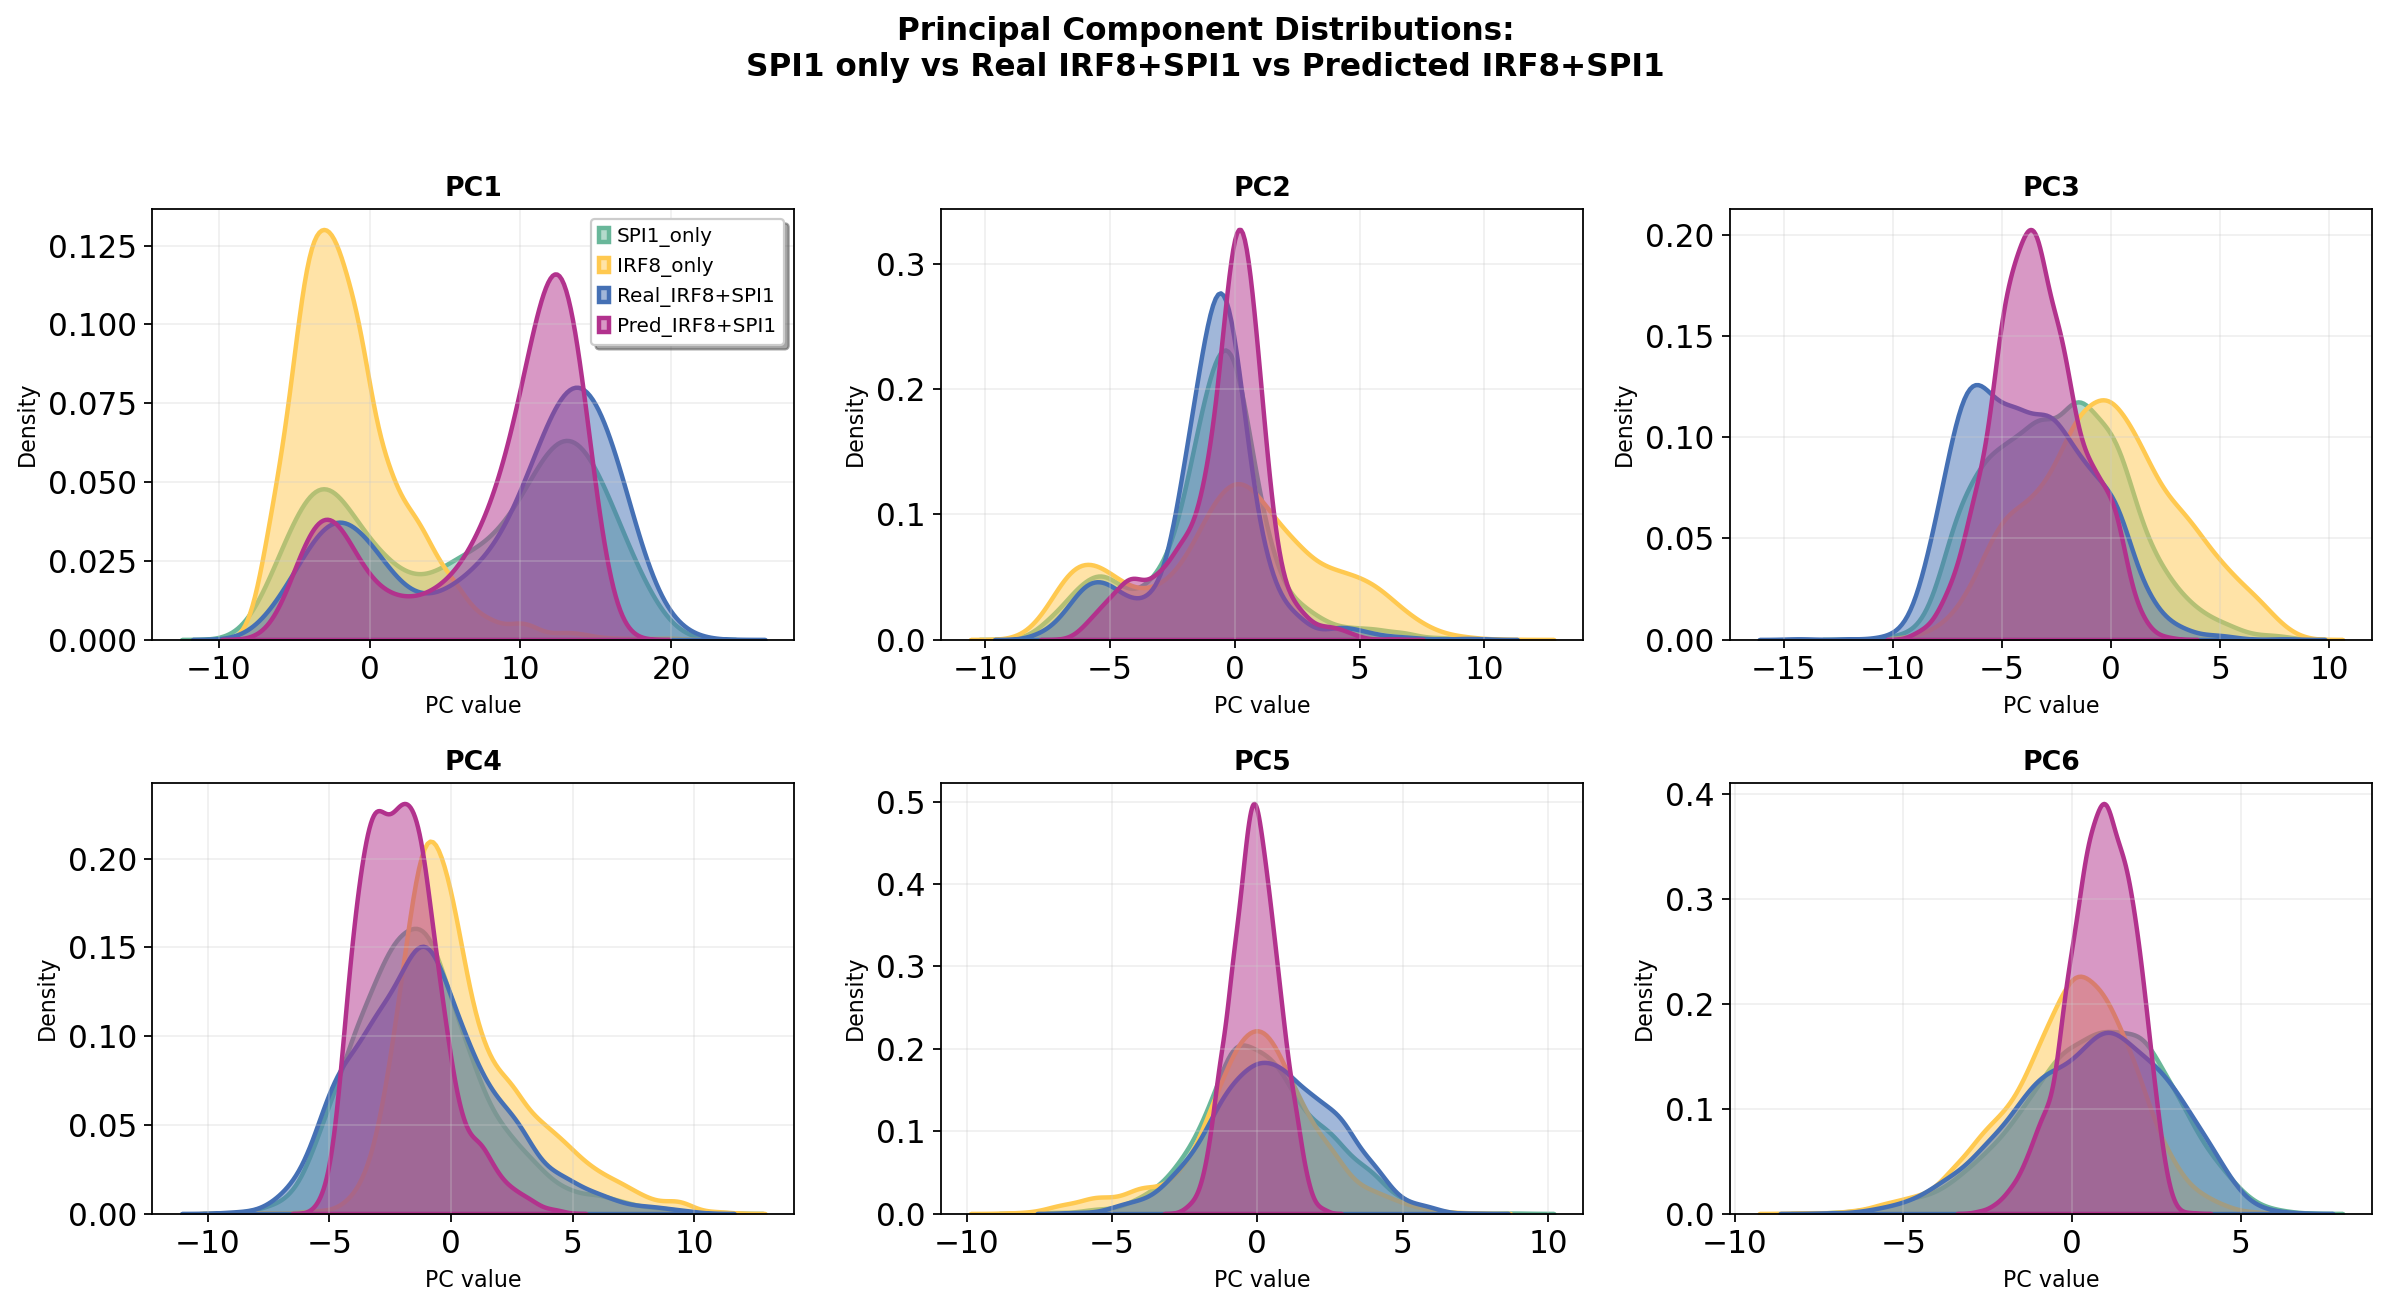

In [24]:
# create adata to compute PCA
adata_combined = sc.concat([
    adata_train[mask_spi1_only].copy(),  # SPI1 only
    adata_train[mask_irf8_only].copy(),  # IRF8 only
    adata_test.copy(),                    # Real IRF8+SPI1
    adata_pred.copy()                     # Predicted IRF8+SPI1
], join='outer')

# add condition tag
adata_combined.obs['condition'] = (
    ['SPI1_only'] * mask_spi1_only.sum() + 
    ['IRF8_only'] * mask_irf8_only.sum() + 
    ['Real_IRF8+SPI1'] * len(adata_test) + 
    ['Pred_IRF8+SPI1'] * len(adata_pred)
)

# calculate PCA
if 'X_pca' not in adata_combined.obsm:
    sc.pp.scale(adata_combined)
    sc.tl.pca(adata_combined, n_comps=6)

# plot
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

colors = {
    'SPI1_only': '#69B79A',
    'IRF8_only': '#FFC950',
    'Real_IRF8+SPI1': '#4570B4',
    'Pred_IRF8+SPI1': '#B2328D'
}

for i, ax in enumerate(axs.flatten()):
    # plot KDE
    for condition, color in colors.items():
        mask = adata_combined.obs['condition'] == condition
        sns.kdeplot(
            x=adata_combined.obsm['X_pca'][mask, i],
            fill=True,
            color=color,
            label=condition,
            alpha=0.5,
            ax=ax,
            linewidth=2
        )
    
    ax.set_title(f'PC{i+1}', fontsize=12, fontweight='bold')
    ax.set_xlabel('PC value', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend(loc='best', fontsize=9, frameon=True, fancybox=True, shadow=True)
    else:
        ax.get_legend().remove() if ax.get_legend() else None

plt.suptitle('Principal Component Distributions:\nSPI1 only vs Real IRF8+SPI1 vs Predicted IRF8+SPI1', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{dir_out}/pc_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()